##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Setup

Let's start with importing TF-2 and all relevant dependencies.

In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  2.8.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  True


2022-03-09 22:41:00.924303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 22:41:00.924684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [27]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


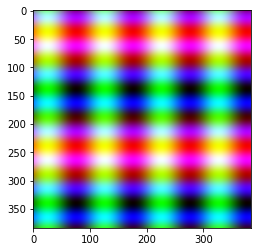

In [58]:
import math

content_image_sketch = np.zeros((384,384,3))

for x in range(384):
    for y in range(384):
        content_image_sketch[x,y,0] = (math.sin(x/32)+1)/2
        content_image_sketch[x,y,1] = (math.sin(y/16)+1)/2
        content_image_sketch[x,y,2] = (math.sin(x/8)+1)/2

plt.imshow(content_image_sketch)

content_image = tf.convert_to_tensor(np.array([content_image_sketch]),dtype=tf.float32)

In [51]:
content_image.shape

TensorShape([1, 384, 384, 3])

In [52]:
np.amax(content_image)

0.9999866

Let's get as well some images to play with.

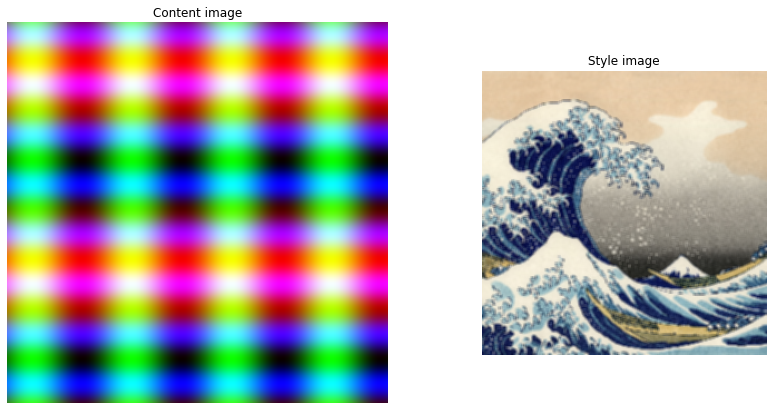

In [59]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

#content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [46]:
content_image.shape

TensorShape([1, 384, 384, 3])

## Import TF-Hub module

In [5]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Demonstrate image stylization

In [60]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

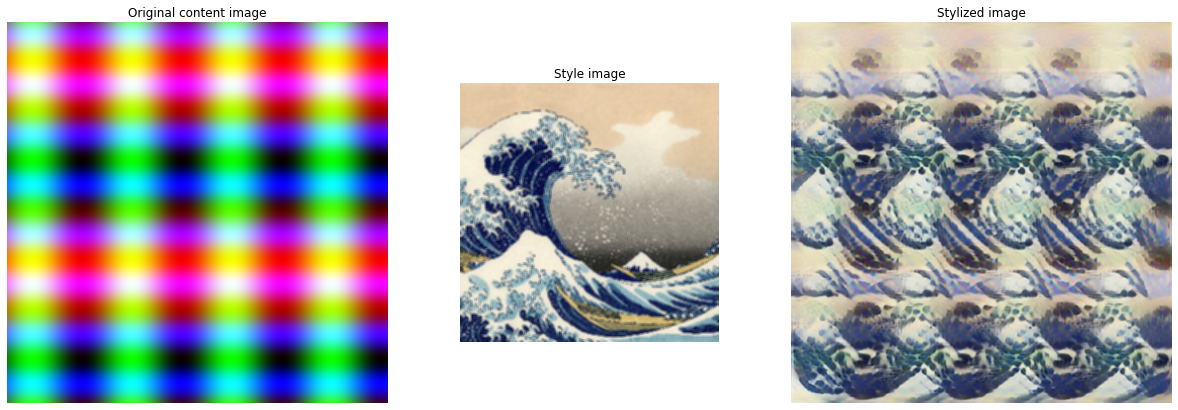

In [61]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], 
       titles=['Original content image', 'Style image', 'Stylized image'])


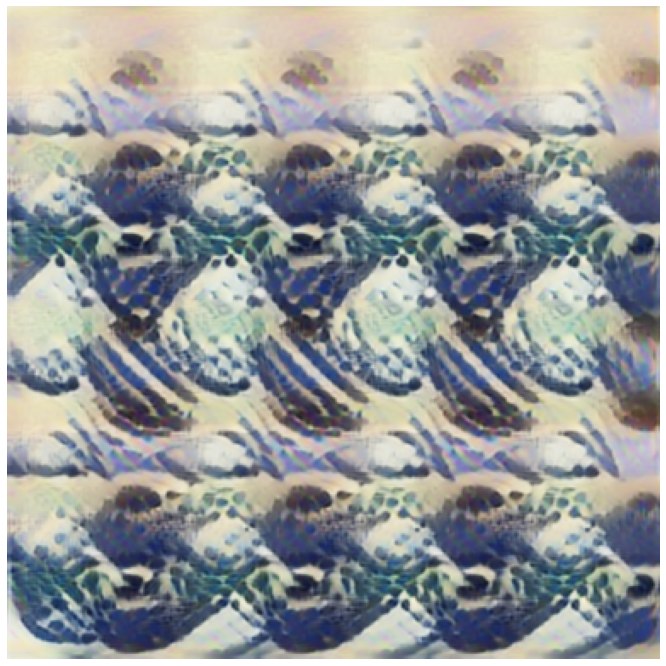

In [62]:
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(stylized_image[0])

In [97]:
frame_num = 200

frames_content = []

for i in range(frame_num):
    content_image_sketch = np.zeros((384,384,3))
    for x in range(384):
        for y in range(384):
            content_image_sketch[x,y,0] = (math.sin(x/32+i*0.1)+1)/2
            content_image_sketch[x,y,1] = (math.sin(y/16-i*0.05)+1)/2
            content_image_sketch[x,y,2] = (math.sin((x+i*0.1)/8)+1)/2
    content_image = tf.convert_to_tensor(np.array([content_image_sketch]),dtype=tf.float32)
    if i%10==0:
        print(i)
    frames_content.append(content_image)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [99]:
print(frames_content[0].shape)
print(len(frames_content))

(1, 384, 384, 3)
200


In [101]:
outputs = []
for i in range(frame_num):
    output = hub_module(tf.constant(frames_content[i]), tf.constant(style_image))
    outputs.append(output)
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


1

In [ ]:
for i in range(frame_num):
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(outputs[i][0][0])
    plt.savefig(f'./outs/generate_{i:03}.png')
    

In [96]:
outputs[0].shape

TensorShape([200, 384, 384, 3])